In [1]:
import pandas as pd

df = pd.read_csv("csv/Servers.csv")
df.head()


,timestamp,active_jobs_per_webserver,active_web_servers,active_jobs_spikeserver
0,0.037115,[1],1.0,0.0
1,0.041546,[0],1.0,0.0
2,0.072598,[1],1.0,0.0
3,0.099880,[0],1.0,0.0
4,0.116936,[1],1.0,0.0


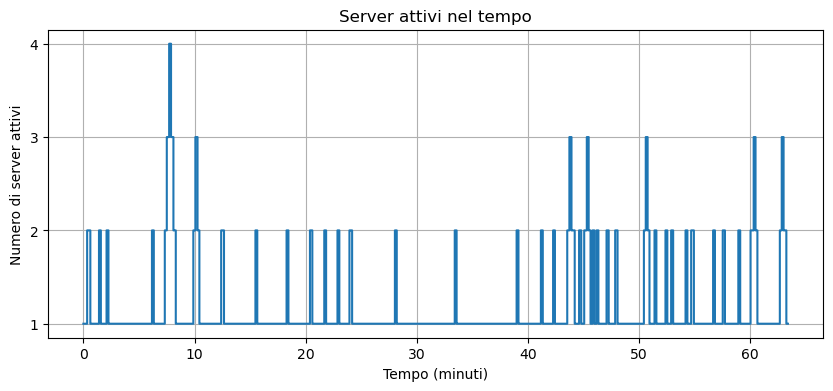

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
# Convertiamo i secondi in minuti
minutes = df["timestamp"] / 60.0

plt.step(minutes, df["active_web_servers"], where="post")
plt.xlabel("Tempo (minuti)")
plt.ylabel("Numero di server attivi")
plt.title("Server attivi nel tempo")
plt.grid(True)

# Assicura che le ordinate abbiano solo numeri interi
plt.yticks(range(int(df["active_web_servers"].min()), int(df["active_web_servers"].max()) + 1))

plt.show()


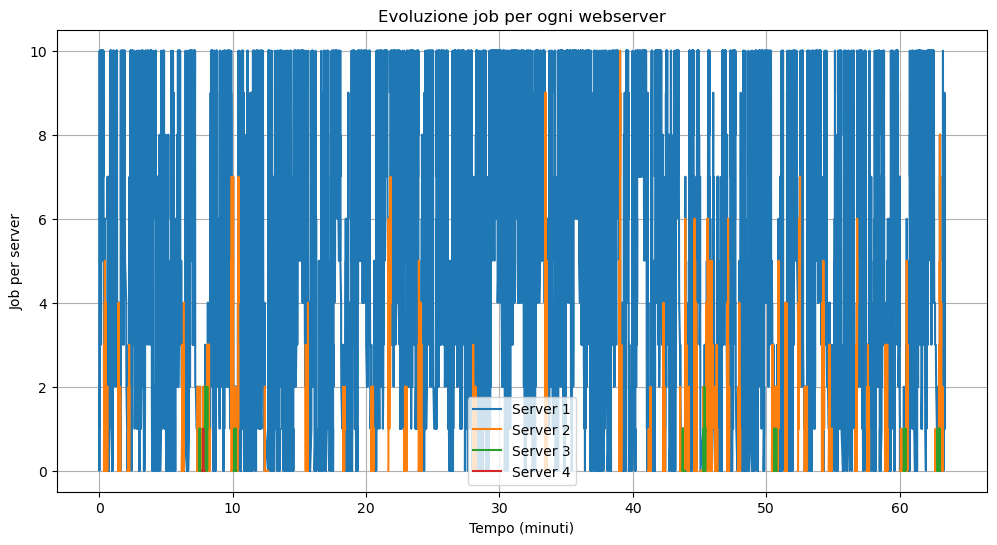

In [3]:
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Funzione robusta per convertire la stringa in lista
def parse_jobs(val):
    if pd.isna(val):          # se è NaN
        return []
    val = str(val).strip()
    if val == "" or val.lower() == "nan":
        return []
    return ast.literal_eval(val)

df["jobs_list"] = df["active_jobs_per_webserver"].apply(parse_jobs)

# Trova il numero massimo di server mai attivi
max_servers = df["jobs_list"].apply(len).max()

# Espande jobs_list in più colonne server_1, server_2, ...
for i in range(max_servers):
    df[f"server_{i+1}_jobs"] = df["jobs_list"].apply(
        lambda lst: lst[i] if i < len(lst) else None
    )

# Converte timestamp in minuti
minutes = df["timestamp"] / 60.0

# Grafico multilinea
plt.figure(figsize=(12, 6))
for i in range(max_servers):
    plt.plot(
        minutes,
        df[f"server_{i+1}_jobs"],
        label=f"Server {i+1}"
    )

plt.xlabel("Tempo (minuti)")
plt.ylabel("Job per server")
plt.title("Evoluzione job per ogni webserver")
plt.grid(True)
plt.legend()
plt.show()



   Departure  ResponseTime  cumulative_avg
0   0.346766      0.038364        0.038364
1   0.353090      0.126773        0.082569
2   0.766902      0.377864        0.181000
3   0.913630      0.706253        0.312314
4   0.959890      0.508361        0.351523


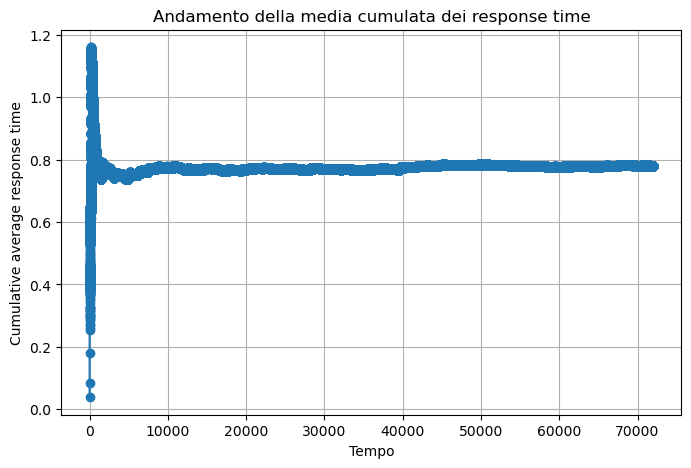

In [13]:
# Carichiamo il file CSV in dfJobs (usa direttamente le intestazioni del file)
dfJobs = pd.read_csv("csv/Jobs.csv")

# Calcolo della media cumulata dei response time
dfJobs["cumulative_avg"] = dfJobs["ResponseTime"].expanding().mean()

# Mostriamo un estratto per verifica
print(dfJobs[["Departure", "ResponseTime", "cumulative_avg"]].head())

# Grafico
plt.figure(figsize=(8,5))
plt.plot(dfJobs["Departure"], dfJobs["cumulative_avg"], marker="o", linestyle="-")
plt.xlabel("Tempo")
plt.ylabel("Cumulative average response time")
plt.title("Andamento della media cumulata dei response time")
plt.grid(True)
plt.show()